#### Import transcript dictionary, convert to dataframe

Read in the transcript after preprocessing it in the previous notebook:

In [3]:
import json
import pandas as pd
import numpy as np

# load transcript dictionary
transcript = json.load(open('transcript.json'))

# convert to dataframe
df = pd.DataFrame()
for t in transcript:
    df_ = pd.DataFrame(list(transcript[t][1]))
    df_['speaker'] = transcript[t][0]
    df_['clip'] = t
    df = pd.concat([df, df_])

# rename speakers
speaker_actor_dict = {'speaker_SPEAKER_00':'junk',
 'speaker_SPEAKER_02':'junk', 
 'speaker_SPEAKER_03':'Sacha Baron Cohen', 
 'speaker_SPEAKER_04':'Lacey Rose',  
 'speaker_SPEAKER_05':'junk',  
 'speaker_SPEAKER_06':'Timothy Simons',
 'speaker_SPEAKER_07':'Henry Winkler',
 'speaker_SPEAKER_08':'Don Cheedle',
 'speaker_SPEAKER_09':'Jim Carrey',
 'speaker_SPEAKER_10':'junk',
  'speaker_SPEAKER_11':'Ted Danson',
}

df['speaker'] = df.speaker.map(speaker_actor_dict)
df = df.query('speaker != "junk"')

Resample the dataframe, grouping by timeframe

In [4]:
threshold = 0
sample_frequency = '30S'

import datetime
df['date_time'] = datetime.datetime(2016, 1,1) + df.start.apply(lambda x: datetime.timedelta(seconds=x))

# set date_time as index and group by user_id and resample by hour, pivot the table
df_sampled = df[['date_time','speaker']].set_index('date_time').groupby('speaker').resample(sample_frequency).count().rename({'speaker':'speaker_count'}, axis=1).reset_index()
df_sampled['minute'] = df_sampled['date_time'].dt.hour*60 + df_sampled['date_time'].dt.minute + df_sampled['date_time'].dt.second/60
df_sampled = pd.pivot_table(df_sampled, values='speaker_count', index=['speaker'], columns=['minute']).fillna(0).apply(lambda x: x>threshold)

Heatmap

<Axes: xlabel='minute', ylabel='speaker'>

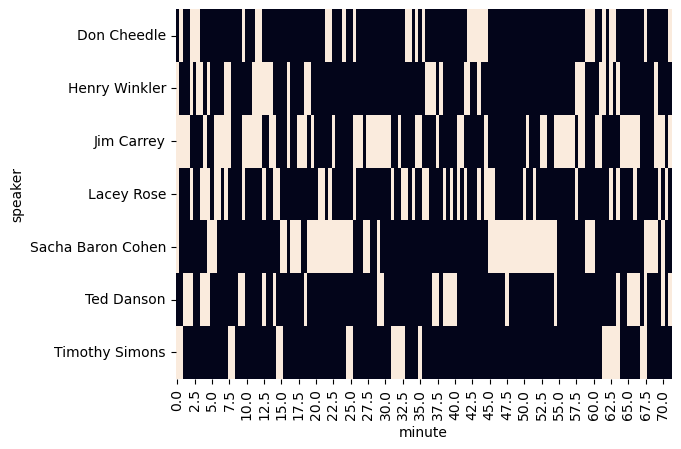

In [5]:
import seaborn as sns
sns.heatmap(df_sampled, cbar=False)

Correlation matrix

[Text(0.5, 1.0, 'Speaker Correlation Matrix')]

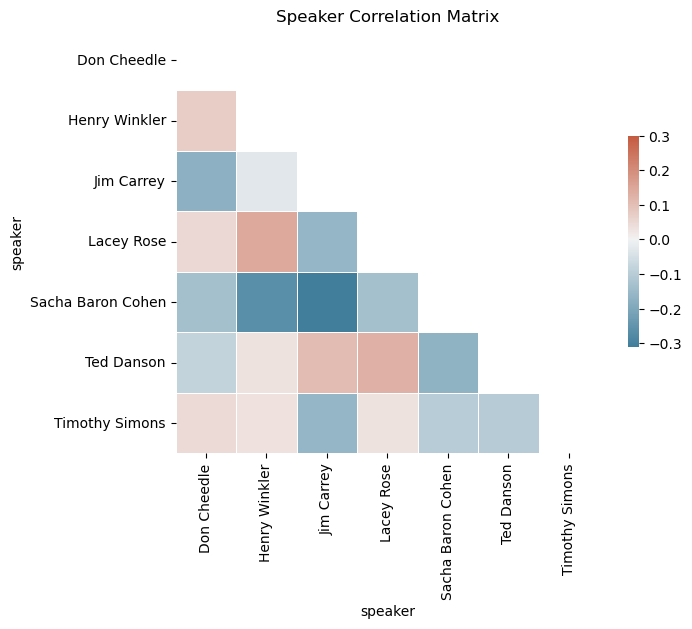

In [6]:
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr = df_sampled.transpose().corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(7.5, 5.5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}).set(title='Speaker Correlation Matrix')

### Looking at words:


In [7]:
df_clips = df.groupby('clip').agg({'content':' '.join, 'start':'first', 'speaker':'first'})

In [8]:
from collections import Counter
import pandas as pd

def remove_top_percentage_words(series, top_percentage, bottom_percentage):

    # Tokenize the text in the input series into words
    words = ' '.join(series).split()

    # Calculate word frequencies for the input series
    word_freq = pd.Series(words).value_counts()

    # Calculate the threshold for the top percentage most common words
    total_words = len(word_freq)
    top_threshold = total_words * (top_percentage)
    bottom_threshold = total_words * (bottom_percentage) 

    # Get the least common words to remove
    top_words_to_remove = word_freq.head(int(top_threshold)).index
    bottom_words_to_remove = word_freq.tail(int(bottom_threshold)).index
    words_to_remove = list(top_words_to_remove) + list(bottom_words_to_remove)

    # Define a function to remove the common words
    def remove_common_words(text):
        words = text.split()
        filtered_words = [word for word in words if word not in top_words_to_remove]
        return ' '.join(filtered_words)

    # Apply the function to the input series
    return series.apply(remove_common_words), words_to_remove

# Remove the top percent of words from the 'content' column
top_percentage = .15
bottom_percentage = 0
df_clips['content'], removed_words = remove_top_percentage_words(df_clips['content'], top_percentage, bottom_percentage)

In [9]:
df_clips = df_clips.query('content != ""')

from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(df_clips['content'].to_numpy())

2023-09-21 07:45:48.034547: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


No supported GPU was found.


In [10]:
from scipy.cluster.vq import kmeans, vq

# cluster the embeddings
k = 6
centroids, distortion = kmeans(embeddings, k)
clusters, _ = vq(embeddings, centroids)
df_clips['cluster'] = pd.Series(clusters, index=df_clips.index)

In [11]:
import wordcloud
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

In [12]:
grouped_df = df_clips.groupby('cluster').content.agg(lambda x: ' '.join(x))
wordclouds = grouped_df.apply(lambda x: WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(x))

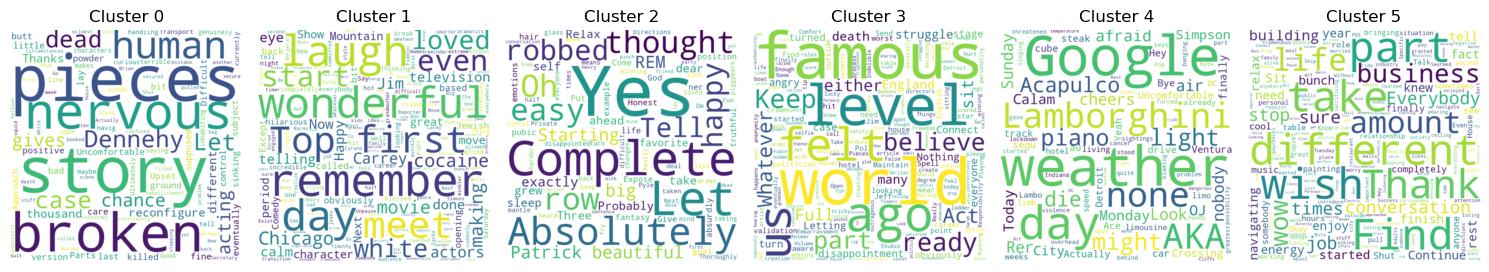

In [13]:
# Create a figure with subplots
fig, axes = plt.subplots(1, len(grouped_df), figsize=(15, 5))  # Adjust figsize as needed

# Iterate through each cluster and its corresponding word cloud
for i, (cluster, wordcloud) in enumerate(zip(grouped_df.index, wordclouds)):
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title(f'Cluster {cluster}')
    axes[i].axis("off")

# Adjust the layout and display the word clouds
plt.tight_layout()
plt.show()

In [14]:
threshold = 0
sample_frequency = '30S'

import datetime
df_clips['date_time'] = datetime.datetime(2016, 1,1) + df_clips.start.apply(lambda x: datetime.timedelta(seconds=x))

# set date_time as index and group by user_id and resample by hour, pivot the table
cluster_sampled = df_clips[['date_time','cluster']].set_index('date_time').groupby('cluster').resample(sample_frequency).count().rename({'cluster':'cluster_count'}, axis=1).reset_index()
cluster_sampled['minute'] = cluster_sampled['date_time'].dt.hour*60 + cluster_sampled['date_time'].dt.minute + cluster_sampled['date_time'].dt.second/60
cluster_sampled = pd.pivot_table(cluster_sampled, values='cluster_count', index=['cluster'], columns=['minute']).fillna(0).apply(lambda x: x>threshold)

<Axes: xlabel='minute', ylabel='cluster'>

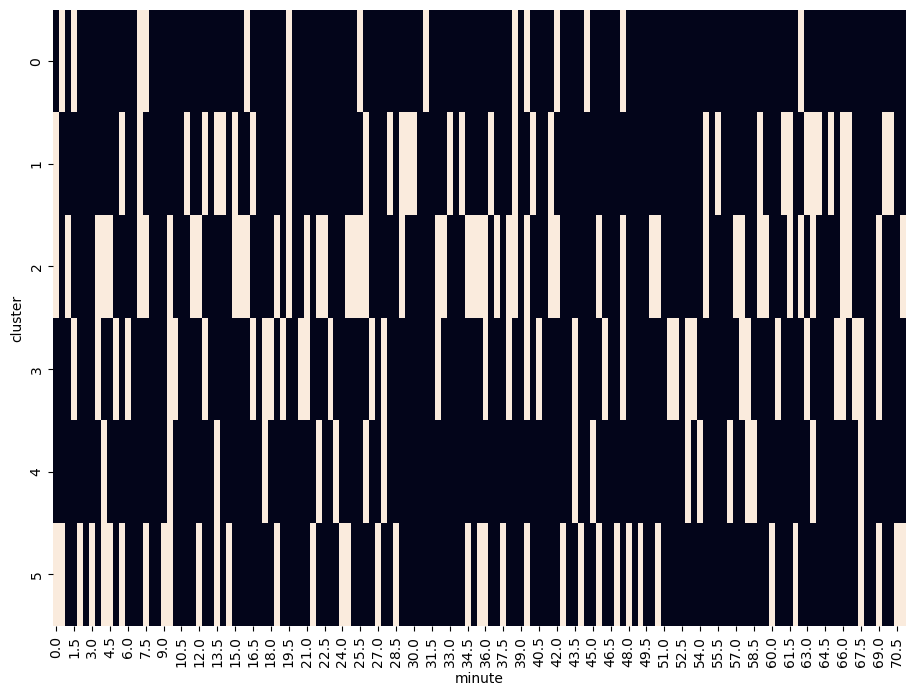

In [15]:
plt.subplots(figsize=(11,8))
sns.heatmap(cluster_sampled, cbar=False)

[Text(0.5, 1.0, 'Cluster Correlation Matrix')]

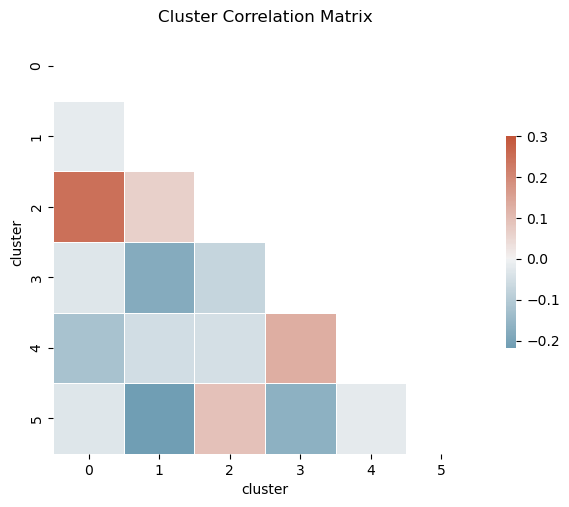

In [16]:
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr = cluster_sampled.transpose().corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(7.5, 5.5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}).set(title='Cluster Correlation Matrix')

### Convert Data to Transition probability matrix

Here I write a function that converts the data into a transition probability matrix, consistent with the state-by-node form of the TPM (transition probability matrix) as described in the [PyPhi Documentation](https://pyphi.readthedocs.io/en/stable/conventions.html#little-endian-convention)

In [18]:
def little_endian_combinations(n):
    if n == 0:
        return [[]]
    
    smaller_combinations = little_endian_combinations(n - 1)
    result = []
    
    for combination in smaller_combinations:
        result.append([0] + combination)
        result.append([1] + combination)
    
    return result

def filter_and_calculate(some_data, state):
    row_equals_state = np.all(some_data == state, axis=1)
    max_row = some_data.shape[0]
    next_rows = np.where(row_equals_state)[0] + 1
    if max_row in next_rows:
        next_rows = next_rows[:len(next_rows) - 1]

    array_filtered = some_data[next_rows]

    pr_ON_t_plus_1 = array_filtered.sum(axis=0)/len(array_filtered)
    if np.isnan(pr_ON_t_plus_1).any():
        return np.zeros(len(state))
    else:
        return pr_ON_t_plus_1
    
def state_by_node_TPM(data):
    possible_states = little_endian_combinations(data.shape[1])
    final_list = []
    for state in possible_states:
        final_list.append(filter_and_calculate(data, state))

    final_array = np.array(final_list)

    return final_array

In [19]:
cluster_transition_data = cluster_sampled.transpose().multiply(1).to_numpy()
actor_transition_data = df_sampled.transpose().multiply(1).to_numpy()

TPM_cluster = state_by_node_TPM(cluster_transition_data)
TPM_actor = state_by_node_TPM(actor_transition_data)

/var/folders/hs/1r2tlf751_l1nl8n9l2_wtpw0000gn/T/ipykernel_26541/4206445415.py:23: RuntimeWarning: invalid value encountered in divide
  pr_ON_t_plus_1 = array_filtered.sum(axis=0)/len(array_filtered)


After creating the TPMs, I import the PyPhi package and calculate phi for a single state and Network.

In [22]:
import pyphi

cluster_network = pyphi.Network(TPM_cluster)
actor_network = pyphi.Network(TPM_actor)

In [24]:
subsystem = pyphi.Subsystem(cluster_network, (0,1,0, 0, 0, 0))
pyphi.compute.phi(subsystem)

Computing concepts:   0%|          | 0/63 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Evaluating Φ cuts:   0%|          | 0/62 [00:00<?, ?it/s]          

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

0.764044